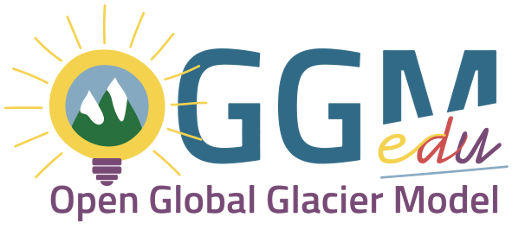

# Temperature index models

Goals of this notebook:

- gain a basic understanding of temperature index models 
- implement OGGM's temperature index model for a glacier of interest

In [5]:
import oggm
from oggm import utils, cfg, workflow, tasks, graphics

In [6]:
cfg.initialize()

2019-05-30 17:57:58: oggm.cfg: Using configuration file: C:\Program Files\Miniconda3\envs\oggm_env\lib\site-packages\oggm\params.cfg


Some settings:

In [10]:
# define a temporary directory to store the required data to
cfg.PATHS['working_dir'] = utils.gettempdir('ti_model')

# set the size of the local glacier map: number of grid points outside the glacier boundaries
# increasing this parameter will (significantly!) increase the amount of data that needs to be downloaded
cfg.PARAMS['border'] = 10

## 1 Background

Glacier melt significantly influences catchment hydrology. Hence, it is useful to have accurate predictions of runoff from glacierized areas. Generally, there are two classes of melt models:

- energy balance models
- temperature index models

Energy balance models are physical models quantifying melt as the residual of the energy balance equation. These models require measurements of net radiation, wind speed, temperature and surface properties to predict melt. On a glacier, spatially well resolved measurements are demanding and hard to maintain. Hence, a simpler model, the temperature index model, is the most common approach to model glacier melt.

Temperature index models assume an empirical relationship between air temperatures and melt rates and are a simplification of the energy balance models. The reasoning is that melt is predominantly influenced by the longwave atmospheric radiation and the sensible heat flux - energy balance components that are highly influenced by air temperature [(Hock, 2003)](https://www.sciencedirect.com/science/article/pii/S0022169403002579). The main reason(s) why temperature index models are commonly used are the wide availability of air temperature measurements and computational efficiency.

## 2 Model setup

The simplest temperature index model relates the amount of ice or snow melt $M$ (mm) to the sum of positive air temperatures $T^+$ ($^\circ$C) by a proportionality factor $DDF$, the *degree-day factor*, for each $n$ time intervals $\Delta t$:

$$\sum_i^{n} M = DDF \sum_i^{n} T^+ \Delta t$$

Commonly, $\Delta t = 1$ day is used - hence the name *degree-day factor*. However, any other time interval $\Delta t$, e.g. hourly or monthly, can be used to determine $DDF$. In practice, the model requires measurements of air temperature and glacier mass balance to estimate $DDF$ - once calculated, $DDF$ can be used to predict melt by only measuring air temperature [(Hock, 2003)](https://www.sciencedirect.com/science/article/pii/S0022169403002579). However, this temperature index model, also called *degree-day model*, is not able to predict glacier surface mass balance.

To model glacier surface mass balance, a more sophisticated temperature index model was developed by [Marzeion et al., (2012)](https://www.the-cryosphere.net/6/1295/2012/tc-6-1295-2012.html). The monthly mass balance $B_i$ at elevation $z$ is computed as

$$B_i(z) = P_i^{solid}(z) - \mu^* \text{max}(T_i(z) - T_{melt}, 0) - \beta^*$$

where $P_i^{Solid}$ is the monthly solid precipitation, $T_i$ the monthly average temperature, $T_{Melt}$ is the monthly average temperature above which ice melt is assumed and $\beta^*$ is a bias correction. $\mu^*$ is the temperature sensitivity of the glacier and it depends on many parameters, mostly glacier specific (e.g., avalanches, topographical shading, cloudiness, ...).

### 2.1 Degrees of freedom

Among others, the temperature sensitivity $\mu^*$, the threshold for melt $T_{Melt}$ and the implicit threshold for solid precipitation $T_{Solid}$ are important degrees of freedom of the model - $T_{Solid}$ is the monthly average temperature below which precipitation is assumed to be solid.

Generally, $T_{Melt}$ and $T_{Solid}$ can vary both spatially and temporally on a specific glacier. However, commonly the two thresholds $T_{Melt}$ and $T_{Solid}$ are assumed to be constant. $T_{Melt}$ and $T_{Solid}$ significantly influence the predicted mass balance $B$ by determining the monthly average temperature and precipitation values which are taken into account in the calculation. 

Both $T_{Melt}$ and $T_{Solid}$ can be determined by a physical reasoning: we know that both snow melts and precipitation becomes solid at around $0^{\circ}$C. Hence, the two thresholds $T_{Melt}$ and $T_{Solid}$ are within a natural range that depends on the climatological conditions at a specific glacier site.

In OGGM, $T_{Melt}$ and $T_{Solid}$ are constants and you can access the default values via the ``cfg`` module:

In [7]:
# the default temperature below which solid precipitation is assumed
print('T_solid = {}°C'.format(cfg.PARAMS['temp_all_solid']))
# the default temperature above which melt is assumed to occur
print('T_melt = {}°C'.format(cfg.PARAMS['temp_melt']))

T_solid = 0.0°C
T_melt = -1.0°C


Similarly, you can use your own $T_{Melt}$ and $T_{Solid}$ if you feel like it:

In [8]:
# don't run this ...
# cfg.PARAMS['temp_all_solid'] = 100
# cfg.PARAMS['temp_melt'] = - 273.15

The temperature sensitivity $\mu^*$ is glacier specific and mostly determined using [ordinary least squares](https://en.wikipedia.org/wiki/Ordinary_least_squares) (OLS). As any other statistical method, OLS is sensitive to the sample size - a general issue in glaciology is that the sample size of annual mass balance records is poor for many glaciers. However, OLS can be used to get an estimate of $\mu^*$ if mass balance data is available.

Assume that a $100$ year long mass balance record together with temperature and precipitation measurements is available for a specific glacier (this is a best case example and only very few glaciers actually have such long records). OLS will find a statistically significant $\mu^*$ which you can happily use to model mass balance. But what happens if you only use $30$ years out of the $100$ year record for OLS? It will find another statistically significant $\mu^*$ that is different from the one determined by the $100$ year record - and another statistically significant $\mu^*$ can be found for each reasonable subset of the original $100$ year record. This implies that $\mu^*$ is generally a time dependent temperature sensitivity $\mu^*(t)$.

For this reason, OGGM implements a calibration procedure, introduced by [Marzeion et al., (2012)](https://www.the-cryosphere.net/6/1295/2012/tc-6-1295-2012.html), to determine a constant glacier specific $\mu^*$ out of the time dependent $\mu^*(t)$ candidates. This calibration is beyond the scope of this notebook and you can read about it in detail [here](https://www.the-cryosphere.net/6/1295/2012/tc-6-1295-2012.html) and check out an example implementation in OGGM [here](https://docs.oggm.org/en/stable/mass-balance.html#calibration).

To access the temperature sensitivity of a specific glacier, you can define a glacier directory:

In [11]:
# this may take a while
gdir = workflow.init_glacier_regions([utils.demo_glacier_id('hef')], from_prepro_level=3)[0]

2019-05-30 18:35:38: oggm.workflow: init_glacier_regions from prepro level 3 on 1 glaciers.
2019-05-30 18:35:38: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers
2019-05-30 18:35:38: oggm.workflow: Multiprocessing: using all available processors (N=4)


If you want to look at your model domain, you can plot it using:

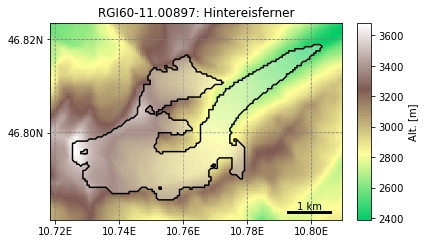

In [13]:
graphics.plot_domain(gdir)

The calibrated temperature sensitivity can be accessed by:

In [14]:
# 'mu_star_glacierwide' is the calibrated temperature sensitivity of the selected glacier
gdir.read_json('local_mustar')

{'mu_star_allsame': True,
 't_star': 1963,
 'rgi_id': 'RGI60-11.00897',
 'bias': -2.7289943003343065,
 'mu_star_per_flowline': [221.27588146249622,
  221.27588146249622,
  221.27588146249622],
 'mu_star_glacierwide': 221.27588146249624,
 'mu_star_flowline_avg': 221.27588146249622}

## 3 Implementation in OGGM

## Take home points

## References

- Hock R., (2003). Temperature index melt modelling in mountain areas. *Journal of Hydrology*, 281, 104-115. https://doi.org/10.1016/S0022-1694(03)00257-9
- Marzeion B., Jarosch A. H. & Hofer M. (2012). Past and future sea-level change from the surface mass balance of glaciers. *The Cryosphere*, 6, 1295-1322. https://doi.org/10.5194/tc-6-1295-2012

## What's next?

[Back to table of contents](welcome.ipynb)